In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from glob import glob
from natsort import natsorted
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sys
import os
import logging
from pathlib import Path

# Set up file paths
file_path = str(Path().absolute())
project_path = str(Path().absolute().parent.parent)
exp_name = file_path.split('/')[-1]

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logging.info(f"Current file directory: {file_path}")
logging.info(f"Current project directory: {project_path}")

os.chdir(project_path)
sys.path.append(project_path)

# Import custom modules
from src.utils import split_intervals

# Read raw data
input_dir = f"{project_path}/data"

files = os.listdir(input_dir)

for file in files:
    if file.endswith('.npy'):
        if file == 'ecog.npy':
            ecog_data = np.load(input_dir + '/' + file, allow_pickle=True)
        if file == 'times_ecog.npy':
            times = np.load(input_dir + '/' + file, allow_pickle=True)
            times = times[0]

# Read upstate event times
upstates = np.load(f"{input_dir}/event_times.npy", allow_pickle=True)

# Get downstates as intervals between upstates
downstates = []
for i in range(len(upstates) - 1):
    downstates.append([upstates[i][1], upstates[i + 1][0]])

2023-04-11 16:04:32,993 - INFO - Current file directory: /Users/septentrionalem/Desktop/study/thesis_2023_travelling_waves/exp/travelling-waves-detection
2023-04-11 16:04:32,994 - INFO - Current project directory: /Users/septentrionalem/Desktop/study/thesis_2023_travelling_waves


In [2]:
# read ibw files till 64 channel
data = ecog_data
# organize data according to channel map
channel_map = np.array([[49,50,51,52,59,58,57,56,55,54,53],
                        [60,61,62,63,54,43,44,45,46,47,65],
                        [42,41,40,39,38,33,34,35,36,37,65],
                        [26,25,24,23,22,17,18,19,20,21,65],
                        [12,13,14,15,16,27,28,29,30,31,65],
                        [1,2,3,4,11,10,9,8,7,6,5]])
data = np.array(data)
data.shape

(64, 1564538)

In [3]:
from neurodsp.filt import filter_signal

# Filter data in beta band
fs = 1000
f_range = (12, 30)
for d in range(data.shape[0]):
    data[d] = filter_signal(data[d], fs, 'bandpass', f_range, remove_edges=False)

In [4]:
data.shape

(64, 1564538)

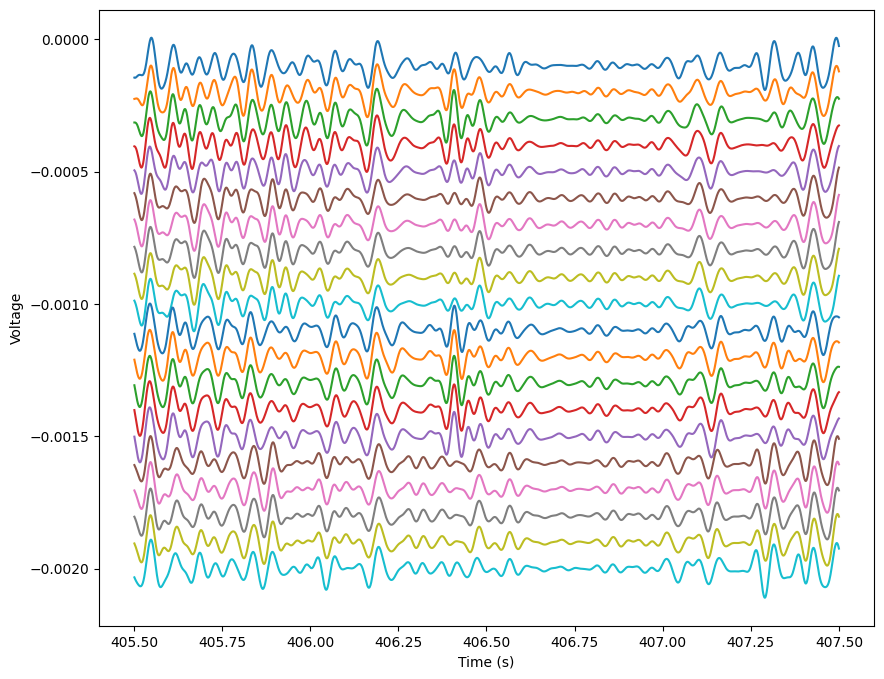

In [4]:
# plot all time series
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
for i in range(1, 64):
    if i > 20:
        continue
    ax.plot(times[404000:406000], data[i, 404000:406000] - i*0.0001)

ax.set_ylabel('Voltage')
ax.set_xlabel('Time (s)')
plt.show()

(1564538,)


Text(0.5, 1.0, 'Time series of filtered ECoG data')

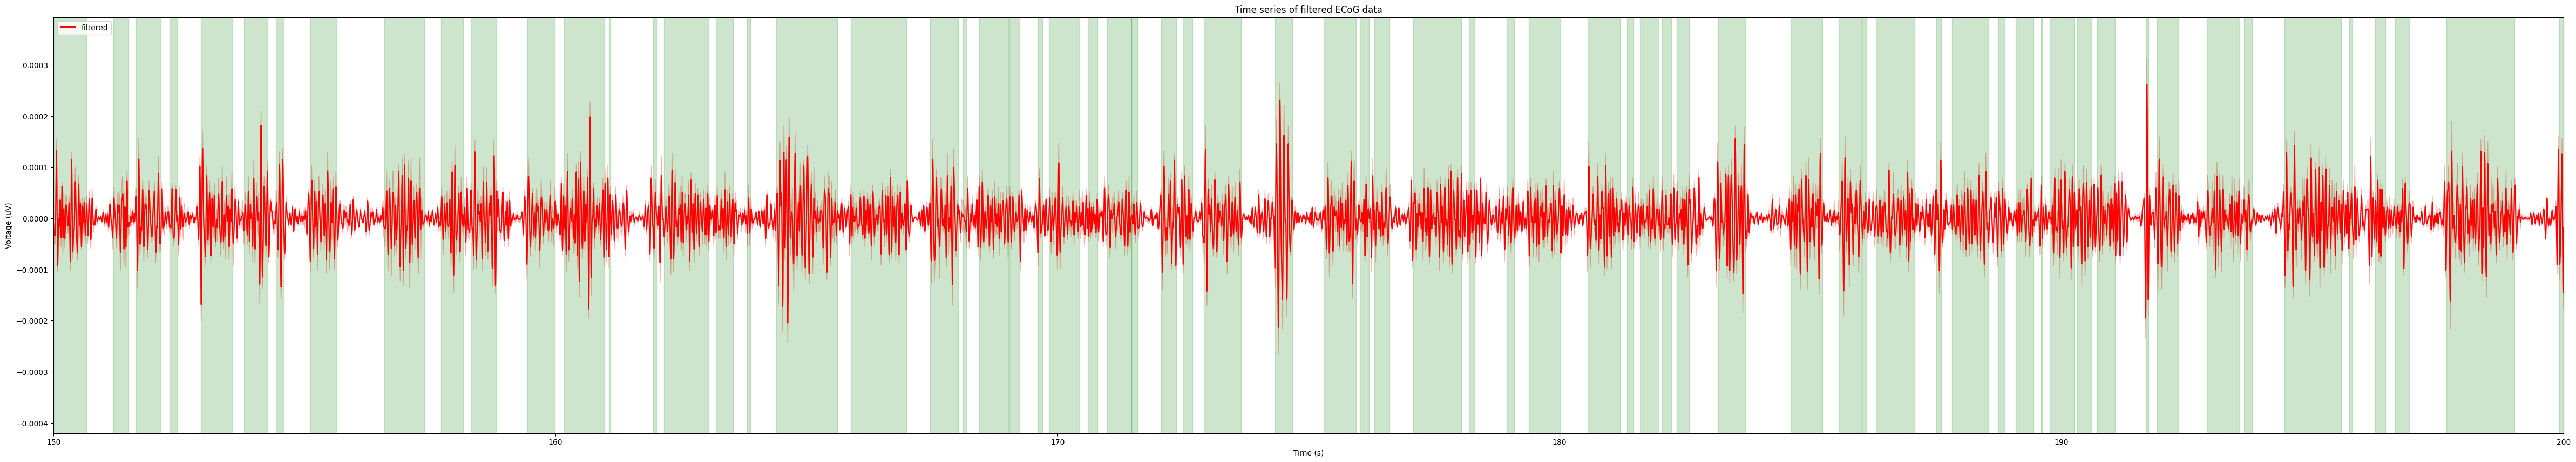

In [15]:
from src.plotting import plot_time_series, plot_filtered_data_with_upstates

sig_filt_mean = np.mean(data, axis=0)

print(sig_filt_mean.shape)
fig =  plt.figure(figsize=(60, 10))
plt.plot(times, sig_filt_mean, label='filtered', color='red')
plt.fill_between(times, sig_filt_mean - np.std(data, axis=0), sig_filt_mean + np.std(data, axis=0), color='red', alpha=0.2)
for i in range(len(upstates)):
    plt.axvspan(upstates[i][0], upstates[i][1], alpha=0.2, color='green')
# plt.axhline(y=threshold_value, color='black', linestyle='--')
plt.legend()
plt.xlim((150, 200))
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.title('Time series of filtered ECoG data')
# # fig.savefig(fig_output_dir + f'/filtered_data_example_with_upstates_{str(xlim[0])}-{str((xlim[1]))}.png')

In [5]:
data = data[:, 404000:406000]
times = times[404000:406000]
print(data.shape, times.shape)

(64, 2000) (2000,)



FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 100 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                         

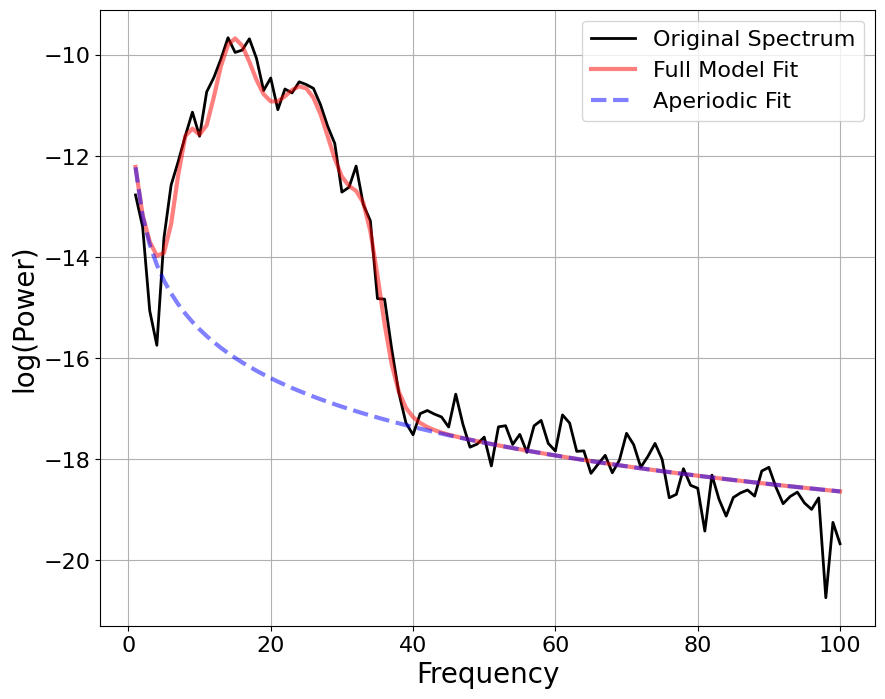

In [12]:
from fooof import FOOOF
from neurodsp.spectral import compute_spectrum_welch

# compute power density spectrum using welch method
# Initialize a FOOOF object
fm = FOOOF()

# Compute a power spectrum
freqs, powers = compute_spectrum_welch(data[60], fs=1000)

# Set the frequency range to fit the model
freq_range = [0, 100] # what freqs range shoul I use? 

# Report: fit the model, print the resulting parameters, and plot the reconstruction
fm.report(freqs, powers, freq_range)

2023-04-11 15:58:11,800 - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2023-04-11 15:58:11,803 - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


ValueError: x and y must have same first dimension, but have shapes (200,) and (190,)

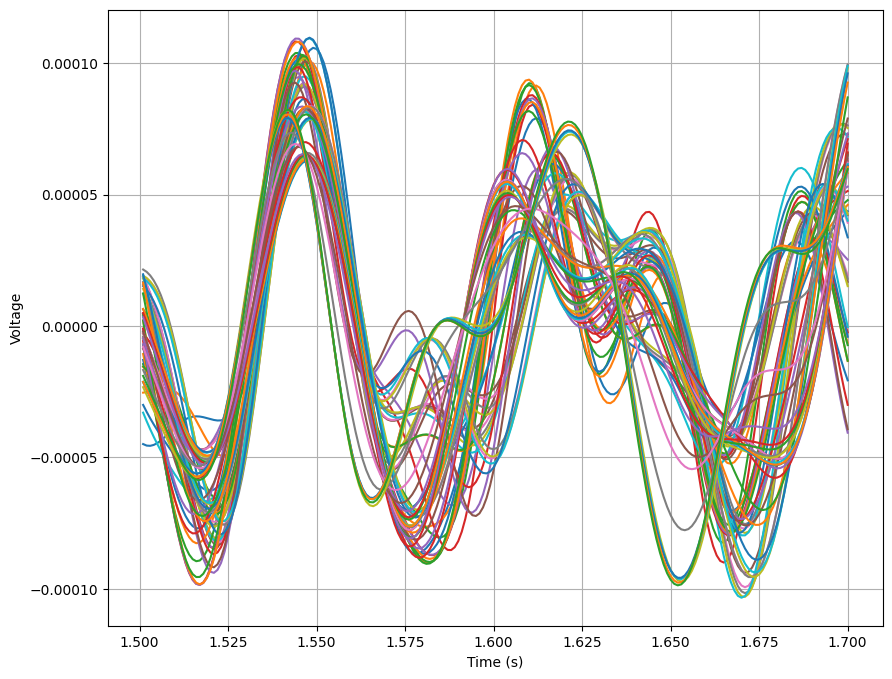

In [13]:
# define figure size
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()

n_frames = 1000

def animate(i):
    # clear cache
    ax.cla()

    # ax.set_ylim(-0.0015, 0.0015)

    i = i * 10
    
    for j in range(1, 64):
        ax.plot(times[i:i+200], data[j, i:i+200] - i*0.01)
        # set grid
        ax.grid()
        # set axis labels
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Voltage')

# set frame by frame as animation
ani = animation.FuncAnimation(plt.gcf(), animate, frames=n_frames)
# save animation
ani.save('travelling_waves.gif', writer='imagemagick', fps=10)

In [6]:
# normalize data to 0-1
data = (data - data.min()) / (data.max() - data.min())

# add 65th channel with zeros
empty = np.zeros((data.shape[1]))
data = np.vstack((data, empty))
data.shape

(65, 2000)

In [7]:
im = np.zeros((channel_map.shape[0], channel_map.shape[1], len(times)))

# Get the positions of the channels in the channel map
x, y = np.where(channel_map > 0)

# Calculate the values for the image
values = data[channel_map[x, y] - 1]
im[x, y, :] = values

2023-04-11 16:00:41,223 - WARNING - MovieWriter imagemagick unavailable; using Pillow instead.
2023-04-11 16:00:41,225 - INFO - Animation.save using <class 'matplotlib.animation.PillowWriter'>


IndexError: index 2000 is out of bounds for axis 2 with size 2000

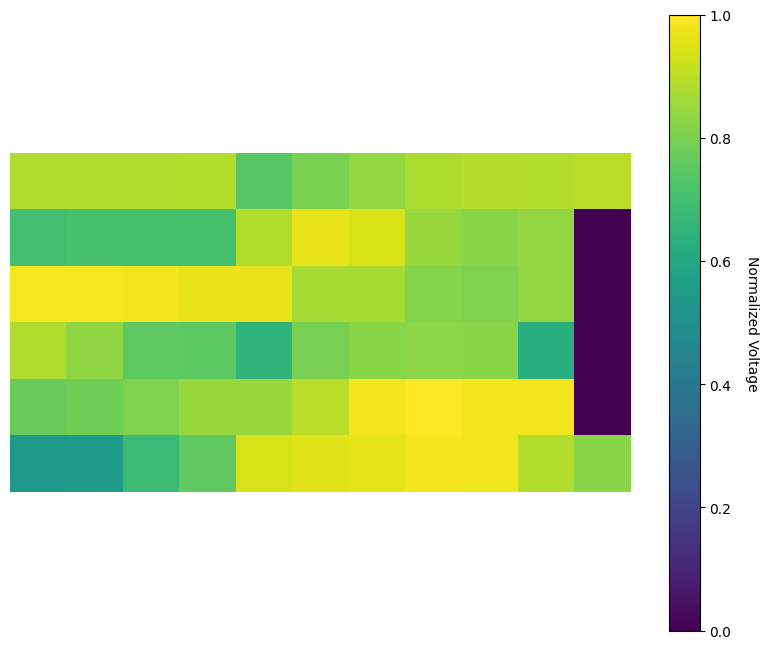

In [8]:
# def animate function
# set figure with 2 axes
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
n_frames = 250
# set color bar
# create a colorbar
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=ax)
# set label for color bar
cbar.set_label('Normalized Voltage', rotation=270, labelpad=20)
def animate(i):
    # clear the axes
    ax.clear()
    ax.clear()

    i = i * 10
    ax.imshow(im[:, :, i])
    ax.axis('off')
    # ax[0].plot(times[:n_frames*10], data[1, :n_frames*10], color='lightblue')
    # # make a vertical line on the plot to show the current time that would move
    # ax[0].axvline(times[i], color='red')
    # # set y limits for the plot between -1 and 1
    # ax[0].set_ylim([0, 1])
    # # set title for the plot
    # ax[0].set_title('Channel #1')
    # # set labels
    # ax[0].set_ylabel('Normalized Voltage')
    # ax[0].set_xlabel('Time (s)')
    
# set frame by frame as animation
ani = animation.FuncAnimation(plt.gcf(), animate, frames=n_frames)
# save animation
ani.save('travelling_waves.gif', writer='imagemagick', fps=5)

Correlation analysis

In [3]:

# read ibw files till 64 channel
data = natsorted(glob('data/w12_18_spont/lfp*.ibw'))
files = [d for d in data if int(d.split('/')[-1].split('.')[0].split('p')[-1]) <= 64]
data = [load_ibw_data(f) for f in files]
times = data[0].times
data = [np.squeeze(d.magnitude) for d in data]
# organize data according to channel map
channel_map = np.array([[49,50,51,52,59,58,57,56,55,54,53],
                        [60,61,62,63,54,43,44,45,46,47,65],
                        [42,41,40,39,38,33,34,35,36,37,65],
                        [26,25,24,23,22,17,18,19,20,21,65],
                        [12,13,14,15,16,27,28,29,30,31,65],
                        [1,2,3,4,11,10,9,8,7,6,5]])
data = np.array(data)
data.shape

(64, 1567540)

(1567540,) [ 0.  0.  0. ... 64. 64. 64.]
(1375881,)
[0.000000e+00 1.000000e-03 2.000000e-03 ... 1.567327e+03 1.567328e+03
 1.567329e+03] s


100%|██████████| 1375880/1375880 [00:00<00:00, 2512233.45it/s]


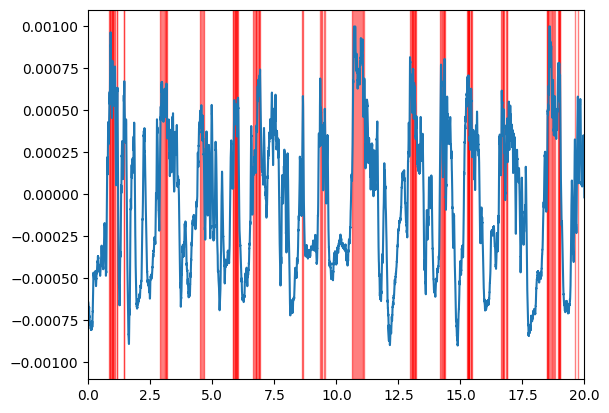

In [15]:
event_times = define_upstate_regions(data, times, threshold_scalar=1.5, binning_size=10, plot=False)

# plot regions
plt.plot(times, data[0])
for event in event_times:
    plt.axvspan(event[0], event[1], alpha=0.5, color='red')

plt.xlim([0, 20])
plt.show()

 